To do

-Need a bit more data analysis at the begining to understand the dataset (graphs etc..) 

-We should dmake use of the data Neighborhoods field. Maybe we can map the nighboorhood to certain demographic details like income (and add that as a column), and work off of that.

-Random Forests 7 Decision trees seem to give best model. But Precision & Recall are still very low, so this model needs to be tuned. Or more feature engineering.

-Some curves like the Precision-Recall curve to understand models.

In [23]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier,VotingClassifier,GradientBoostingClassifier,AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate,cross_val_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, f1_score, confusion_matrix
from sklearn.metrics import classification_report 
import matplotlib.pyplot as plt
import random
import seaborn as sns
from sklearn.model_selection import GridSearchCV

In [2]:
import warnings 
warnings.filterwarnings('ignore')
pd.options.display.max_columns = None

## 1. Loading Data and Inspecting

In [3]:
#Source
#https://www.kaggle.com/joniarroba/noshowappointments
data = pd.read_csv('KaggleV2-May-2016.csv')

#No show columns (porcessed and saved to disk)
data_no_shows = pd.read_csv('prior_no_shows.txt')

In [257]:
data.head()

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show
0,2.987250e+13,5642903,F,2016-04-29T18:38:08Z,2016-04-29T00:00:00Z,62,JARDIM DA PENHA,0,1,0,0,0,0,No
1,5.589978e+14,5642503,M,2016-04-29T16:08:27Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,0,0,0,0,0,No
2,4.262962e+12,5642549,F,2016-04-29T16:19:04Z,2016-04-29T00:00:00Z,62,MATA DA PRAIA,0,0,0,0,0,0,No
3,8.679512e+11,5642828,F,2016-04-29T17:29:31Z,2016-04-29T00:00:00Z,8,PONTAL DE CAMBURI,0,0,0,0,0,0,No
4,8.841186e+12,5642494,F,2016-04-29T16:07:23Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,1,1,0,0,0,No


We should do some sort of geogrpahic categorical breakdown. Maybe map the nighboorhood to certain demographic details, and work off of those.

In [10]:
data.describe()

,PatientId,AppointmentID,Age,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received
count,1.105270e+05,1.105270e+05,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000
mean,1.474963e+14,5.675305e+06,37.088874,0.098266,0.197246,0.071865,0.030400,0.022248,0.321026
std,2.560949e+14,7.129575e+04,23.110205,0.297675,0.397921,0.258265,0.171686,0.161543,0.466873
min,3.921784e+04,5.030230e+06,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4.172614e+12,5.640286e+06,18.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,3.173184e+13,5.680573e+06,37.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,9.439172e+13,5.725524e+06,55.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,9.999816e+14,5.790484e+06,115.000000,1.000000,1.000000,1.000000,1.000000,4.000000,1.000000


In [11]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110527 entries, 0 to 110526
Data columns (total 14 columns):
PatientId         110527 non-null float64
AppointmentID     110527 non-null int64
Gender            110527 non-null object
ScheduledDay      110527 non-null object
AppointmentDay    110527 non-null object
Age               110527 non-null int64
Neighbourhood     110527 non-null object
Scholarship       110527 non-null int64
Hipertension      110527 non-null int64
Diabetes          110527 non-null int64
Alcoholism        110527 non-null int64
Handcap           110527 non-null int64
SMS_received      110527 non-null int64
No-show           110527 non-null object
dtypes: float64(1), int64(8), object(5)
memory usage: 11.8+ MB


In [12]:
#Analysis

The dataset is imbalanced (approx. 80/20 ratio of No/Yes).  Measuring classifier accuracy is probably not useful unless the accuracy is well over 80%. 

In [259]:
no = len(data[data['No-show']=='No'])
yes = len(data[data['No-show']=='Yes'])
total = len(data)

print('Number of Rows with No-Show = Yes: ', yes,'(',np.round(yes/total*100,2),'%), Number of rows with No-show = No: ', no,'(',np.round(no/total*100,2),'%)')

Number of Rows with No-Show = Yes:  22319 ( 20.19 %), Number of rows with No-show = No:  88208 ( 79.81 %)


## 2. Editing/Adding Features and Labels

**New Features Created:**

"days_to_appt" - days between scheduling date and appt date (numerical)

"day_of_appt" - day of the week of the appt (categorical)

"month_of_appt" - month of the year of the appt (categorical)

"day_of_scheduling" - day of week appt was scheduled on (categorical)

"month_of_scheduling" - month of year appt was scheduled on (categorical)

"prior_visits" - number of times same patient has visited previously up until the appointment date in the row

"prior_no_shows" - number of no shows by same appointment up until the appointment date in the row



**Final Features/Labels of Interest:**

Numerical: Age, days_to_appt, Handcap

Categorical: Gender, Hipertension, Diabetes, Alcoholism, SMS_received, day_of_appt, month_of_appt, day_of_scheduling, month_of_scheduling 

Labels: No-show (Yes=1, No=0)



In [4]:
# map labels to to 1s and zeros
data['Labels'] = data['No-show'].map({'Yes': 1, 'No': 0})

In [5]:
# convert date objects to datetime format (without time part)
data['ScheduledDayDT'] = pd.to_datetime(data['ScheduledDay']).dt.date
data['ScheduledDayDT'] = pd.to_datetime(data['ScheduledDayDT'])
data['AppointmentDayDT'] = pd.to_datetime(data['AppointmentDay'])

In [6]:
# create new feature - "days_to_appt" - no. of days between scheduled date and appt date
data['time_between_appts'] = data['AppointmentDayDT']-data['ScheduledDayDT']
data['days_to_appt'] = data['time_between_appts']/np.timedelta64(1,'D')

In [7]:
# create new features - day of the week and month of the year of the scheduling and appointment dates
data['day_of_appt'] = data['AppointmentDayDT'].dt.dayofweek
data['day_of_scheduling'] = data['ScheduledDayDT'].dt.dayofweek
data['month_of_appt'] = data['AppointmentDayDT'].dt.month
data['month_of_scheduling'] = data['ScheduledDayDT'].dt.month

In [8]:
#combine with no show file to get the following columns: prior_no_shows,prior_no_shows?,prior_visits
data=pd.merge(data, data_no_shows, left_index=True, right_index=True)


In [9]:
#dont need to work with all 100k rows. Take a sample of 10,000 rows
data=data.sample(10000)

In [16]:
data.head()

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show,Labels,ScheduledDayDT,AppointmentDayDT,time_between_appts,days_to_appt,day_of_appt,day_of_scheduling,month_of_appt,month_of_scheduling,Unnamed: 0,prior_no_shows,prior_no_shows?,prior_visits
0,2.987250e+13,5642903,F,2016-04-29T18:38:08Z,2016-04-29T00:00:00Z,62,JARDIM DA PENHA,0,1,0,0,0,0,No,0,2016-04-29,2016-04-29,0 days,0.0,4,4,4,4,0,0,0,0
1,5.589978e+14,5642503,M,2016-04-29T16:08:27Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,0,0,0,0,0,No,0,2016-04-29,2016-04-29,0 days,0.0,4,4,4,4,1,0,0,0
2,4.262962e+12,5642549,F,2016-04-29T16:19:04Z,2016-04-29T00:00:00Z,62,MATA DA PRAIA,0,0,0,0,0,0,No,0,2016-04-29,2016-04-29,0 days,0.0,4,4,4,4,2,0,0,0
3,8.679512e+11,5642828,F,2016-04-29T17:29:31Z,2016-04-29T00:00:00Z,8,PONTAL DE CAMBURI,0,0,0,0,0,0,No,0,2016-04-29,2016-04-29,0 days,0.0,4,4,4,4,3,0,0,0
4,8.841186e+12,5642494,F,2016-04-29T16:07:23Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,1,1,0,0,0,No,0,2016-04-29,2016-04-29,0 days,0.0,4,4,4,4,4,0,0,0


Below looks at the % of no shows within each category

In [25]:
num_attribs = ['Age','days_to_appt',"count_visits","prior_no_shows","prior_visits"]
cat_attribs = ['Gender','Hipertension','Diabetes','Alcoholism','SMS_received','day_of_appt',
          'Scholarship','month_of_appt','day_of_scheduling','month_of_scheduling','Handcap','Neighbourhood']

In [26]:
#Test
#data[data["Labels"]==1][data["Gender"]=="F"].count()
#data[[data["Gender"]=="F"].count()

In [43]:
pd.DataFrame(data["Neighbourhood"].unique())

,0
0,JARDIM DA PENHA
1,MATA DA PRAIA
2,PONTAL DE CAMBURI
3,REPÚBLICA
4,GOIABEIRAS
5,ANDORINHAS
6,CONQUISTA
7,NOVA PALESTINA
8,DA PENHA
9,TABUAZEIRO


In [40]:
#neighborhood
pd.set_option('display.max_rows', 500)
(data[data["Labels"]==1].groupby(by='Neighbourhood')["Labels"].count()/data.groupby(by='Neighbourhood')["Labels"].count())


Neighbourhood
AEROPORTO                      0.125000
ANDORINHAS                     0.230327
ANTÔNIO HONÓRIO                0.184502
ARIOVALDO FAVALESSA            0.219858
BARRO VERMELHO                 0.215130
BELA VISTA                     0.201363
BENTO FERREIRA                 0.224942
BOA VISTA                      0.185897
BONFIM                         0.198341
CARATOÍRA                      0.230409
CENTRO                         0.210858
COMDUSA                        0.180645
CONQUISTA                      0.188457
CONSOLAÇÃO                     0.172238
CRUZAMENTO                     0.217454
DA PENHA                       0.193505
DE LOURDES                     0.154098
DO CABRAL                      0.157143
DO MOSCOSO                     0.222760
DO QUADRO                      0.164900
ENSEADA DO SUÁ                 0.221277
ESTRELINHA                     0.197026
FONTE GRANDE                   0.218475
FORTE SÃO JOÃO                 0.183166
FRADINHOS                 

In [27]:
#below breaks down % ofno shows by category. E.g.e first output said that 20% of female are no shows
for i in cat_attribs:

    print(data[data["Labels"]==1].groupby(by=i)["Labels"].count()/data.groupby(by=i)["Labels"].count())
    
    #storng ones are SMS,day_of_appt,Scholarship,day_of_scheduling,month_of_scheduling,handcap

Gender
F    0.203146
M    0.199679
Name: Labels, dtype: float64
Hipertension
0    0.209037
1    0.173020
Name: Labels, dtype: float64
Diabetes
0    0.203628
1    0.180033
Name: Labels, dtype: float64
Alcoholism
0    0.201946
1    0.201488
Name: Labels, dtype: float64
SMS_received
0    0.167033
1    0.275745
Name: Labels, dtype: float64
day_of_appt
0    0.206471
1    0.200936
2    0.196892
3    0.193541
4    0.212261
5    0.230769
Name: Labels, dtype: float64
Scholarship
0    0.198072
1    0.237363
Name: Labels, dtype: float64
month_of_appt
4    0.195672
5    0.207865
6    0.184568
Name: Labels, dtype: float64
day_of_scheduling
0    0.197574
1    0.202194
2    0.201096
3    0.204725
4    0.205498
5    0.041667
Name: Labels, dtype: float64
month_of_scheduling
1     0.300000
2     0.291815
3     0.330935
4     0.309760
5     0.174560
6     0.100800
11         NaN
12    0.311475
Name: Labels, dtype: float64
Handcap
0    0.202353
1    0.179236
2    0.202186
3    0.230769
4    0.333333
Name:

Correlation and Heat map

In [21]:
#same thing as above, but for numerical attributes

#all good

data["Age_Round"]=round(data["Age"],-1)
print(data[data["Labels"]==1].groupby(by="Age_Round")["Labels"].count()/data.groupby(by='Age_Round')["Labels"].count())
    
#data["Age_Round"]=round(data["Age"],-1)
print(data[data["Labels"]==1].groupby(by="prior_no_shows")["Labels"].count()/data.groupby(by='prior_no_shows')["Labels"].count())

data["days_to_appt_Round"]=round(data["days_to_appt"],-1)
print(data[data["Labels"]==1].groupby(by="days_to_appt_Round")["Labels"].count()/data.groupby(by='days_to_appt_Round')["Labels"].count())

print(data[data["Labels"]==1].groupby(by="prior_visits")["Labels"].count()/data.groupby(by='prior_visits')["Labels"].count())

Age_Round
0      0.186243
10     0.237810
20     0.253683
30     0.229771
40     0.211216
50     0.183914
60     0.159585
70     0.151392
80     0.158291
90     0.166972
100    0.153846
120    0.600000
Name: Labels, dtype: float64
prior_no_shows
0     0.192154
1     0.250501
2     0.279139
3     0.320402
4     0.423077
5     0.484127
6     0.517241
7     0.730769
8     0.500000
9     0.750000
10    0.818182
11    0.300000
12    1.000000
13    1.000000
14    1.000000
15    1.000000
Name: Labels, dtype: float64
days_to_appt_Round
-10.0     1.000000
 0.0      0.117426
 10.0     0.284910
 20.0     0.332454
 30.0     0.319453
 40.0     0.350464
 50.0     0.320548
 60.0     0.302242
 70.0     0.306802
 80.0     0.307487
 90.0     0.250000
 100.0    0.342105
 110.0    0.083333
 120.0         NaN
 130.0    0.428571
 140.0    0.444444
 150.0    1.000000
 160.0    0.380952
 170.0    0.125000
 180.0    0.307692
Name: Labels, dtype: float64
prior_visits
0     0.193800
1     0.212884
2     0.219641

In [ ]:
#Correlation analysis
corr=data.corr()
corr=abs(corr)
corr["Labels"].sort_values()
#corr.sort_values(ascending=False)

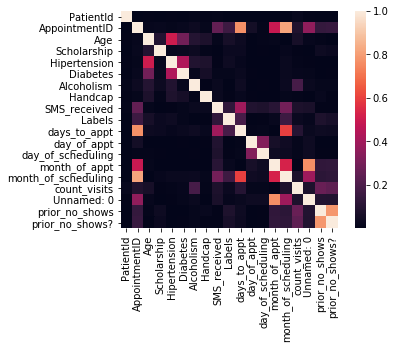

In [56]:
#Heatmap
ax = sns.heatmap(corr,  square=True)

In [24]:
data.columns

Index(['PatientId', 'AppointmentID', 'Gender', 'ScheduledDay',
       'AppointmentDay', 'Age', 'Neighbourhood', 'Scholarship', 'Hipertension',
       'Diabetes', 'Alcoholism', 'Handcap', 'SMS_received', 'No-show',
       'Labels', 'ScheduledDayDT', 'AppointmentDayDT', 'time_between_appts',
       'days_to_appt', 'day_of_appt', 'day_of_scheduling', 'month_of_appt',
       'month_of_scheduling', 'Unnamed: 0', 'prior_no_shows',
       'prior_no_shows?', 'prior_visits', 'Age_Round', 'days_to_appt_Round'],
      dtype='object')

## 3. Prepare for Modelling

The cleaned data is divided into train/test sets (70/30) ratio. OneHotEncoder() is used for all categorical features (except the ones already encoded from the source) and StandardScaler() for numerical features.

In [10]:
# keep only desired features and labels
data_clean = data[['Gender','Age','Hipertension','Diabetes','Alcoholism','Handcap','SMS_received','Scholarship',
                  'Labels','day_of_appt','day_of_scheduling','days_to_appt','month_of_appt','month_of_scheduling','prior_visits','prior_no_shows']]

In [11]:
# This function prepares the datafame, dividing into train/test, seperating features from labels, and scaling/one hot encoding
# split into train/test, stratify by Label column
train_set,test_set = train_test_split(data_clean,test_size=0.2,stratify=data_clean["Labels"])
print(len(train_set), "train +", len(test_set), "test")

# divide into features/labels
train_features = train_set.drop('Labels',axis=1)
train_labels = train_set[['Labels']]
test_features = test_set.drop('Labels',axis=1)
test_labels = test_set[['Labels']]

8000 train + 2000 test


In [12]:
# transform numerical and categorical features using StandardScaler() and OneHotEncoder()
#dont have to onehot encode already onehot encoded columns
num_attribs = ['Age','days_to_appt',"prior_visits","prior_no_shows"]
cat_attribs = ['Gender','Hipertension','Diabetes','Alcoholism','SMS_received','day_of_appt',
          'Scholarship','month_of_appt','day_of_scheduling','month_of_scheduling','Handcap']

#storng ones are SMS,day_of_appt,Scholarship,day_of_scheduling,month_of_scheduling


#subset to only categorical features that need to be one hot encoded. A few are alreayd encoded from the data source
cat_attribs_one_hot= ['Handcap','Gender','day_of_appt','month_of_appt','day_of_scheduling','month_of_scheduling']

#other_cat_attribs=list(set(cat_attribs) -set(cat_attribs_one_hot))

pipeline_features = ColumnTransformer(
        remainder='passthrough',
    transformers=[
        ("num",StandardScaler(),num_attribs),
     ("cat",OneHotEncoder(),cat_attribs_one_hot)
    ]
)

train_features_prepared = pipeline_features.fit_transform(train_features)
train_labels_prepared = train_labels.values

test_features_prepared = pipeline_features.transform(test_features)
test_labels_prepared = test_labels.values

In [12]:
train_features_prepared.shape

(88421, 39)

## 4. Testing Some Models

A few classifiers are trained below, with 3 cross-validation folds. 

For KNN, sqrt(n_samples) was used as n_neighbors, as usually suggested in literature.


In [13]:
metrics=['accuracy', 'precision', 'recall', 'f1', 'roc_auc']

In [13]:
# This Function Runs Several Classifiers on Training Data with 3 cv-folds, Prints Out "metric" score of each Model
 
def testClassifiers(train_features,train_labels,metrics=[]):
    LOG=LogisticRegression()
    DTC=DecisionTreeClassifier()
    RFC=RandomForestClassifier(n_estimators=10)
    KNN=KNeighborsClassifier()
    SGD=SGDClassifier()
    SVC_CLF = SVC(kernel="rbf") #This runs very slow!

    classifier_list = [LOG,DTC,RFC,KNN]# RFC and SVC_CLF take long.

    for c in classifier_list:
        print(type(c).__name__)
        for m in metrics:
            #can use cross_validate with multiple scores insteadto make this run faster
            cv_results = cross_val_score(c,train_features_prepared,train_labels_prepared,cv=3,scoring=m)
            print('-------------------')
            print('Scoring Metric: ', m)
            print('Scores: ',cv_results)
            print('Mean Score: ',np.round(np.mean(cv_results),2))
            print('')

In [ ]:
testClassifiers(train_features,train_labels, ['accuracy', 'precision', 'recall', 'f1', 'roc_auc'])

LogisticRegression
-------------------
Scoring Metric:  accuracy
Scores:  [0.79561648 0.79646468 0.79659349]
Mean Score:  0.8

-------------------
Scoring Metric:  precision
Scores:  [0.40374332 0.43490305 0.44086022]
Mean Score:  0.43

-------------------
Scoring Metric:  recall
Scores:  [0.02536962 0.02637769 0.02755839]
Mean Score:  0.03

-------------------
Scoring Metric:  f1
Scores:  [0.04773949 0.04973863 0.05187411]
Mean Score:  0.05

-------------------
Scoring Metric:  roc_auc
Scores:  [0.67768446 0.67508426 0.68094029]
Mean Score:  0.68

DecisionTreeClassifier
-------------------
Scoring Metric:  accuracy
Scores:  [0.73145823 0.73234037 0.73117769]
Mean Score:  0.73

-------------------
Scoring Metric:  precision
Scores:  [0.33085823 0.32444444 0.3256705 ]
Mean Score:  0.33

-------------------
Scoring Metric:  recall
Scores:  [0.31586022 0.30913978 0.31003193]
Mean Score:  0.31

-------------------
Scoring Metric:  f1
Scores:  [0.32322202 0.31571675 0.31875107]
Mean Score: 

Random Forests seem to give best models. But Precision & Recall are still very low, so this model needs to be tuned. Or more feature engineering.

Next steps
1)need a bit more data analysis at the begining to understand the dataset (graphs etc..) 2. some curves like the Precision-Recall curve to understand models.

In [ ]:
#Try voting classifiers

In [24]:
#all models

LOG=LogisticRegression()
DTC=DecisionTreeClassifier()
RFC=RandomForestClassifier(n_estimators=10)
KNN=KNeighborsClassifier()
SGD=SGDClassifier()
SVC_CLF = SVC(kernel="rbf") #This runs very slow!
gbc = GradientBoostingClassifier()
ada = AdaBoostClassifier ( DecisionTreeClassifier ( max_depth = 1 ), n_estimators = 20 , algorithm = "SAMME.R" , learning_rate = 0.5 )

    
voting_clf = VotingClassifier(
    estimators=[('lr', LOG), ('dt', DTC),()],
    voting='soft')

In [25]:
#fit model
ada.fit(train_features_prepared,train_labels_prepared)

AdaBoostClassifier(algorithm='SAMME.R',
                   base_estimator=DecisionTreeClassifier(class_weight=None,
                                                         criterion='gini',
                                                         max_depth=1,
                                                         max_features=None,
                                                         max_leaf_nodes=None,
                                                         min_impurity_decrease=0.0,
                                                         min_impurity_split=None,
                                                         min_samples_leaf=1,
                                                         min_samples_split=2,
                                                         min_weight_fraction_leaf=0.0,
                                                         presort=False,
                                                         random_state=None,
                             

In [26]:
#Prediction
y_train_pred = ada.predict(train_features_prepared)

In [27]:
#Scores
print('Accuracy =' ,  accuracy_score(train_labels_prepared, y_train_pred))
print('precision = ' , precision_score(train_labels_prepared, y_train_pred))
print('recall  = ', recall_score(train_labels_prepared, y_train_pred))
print('f1  = ', f1_score(train_labels_prepared, y_train_pred))
print('auc = ', roc_auc_score(train_labels_prepared, y_train_pred))

Accuracy = 0.7995
precision =  0.8
recall  =  0.014796547472256474
f1  =  0.029055690072639227
auc =  0.506927906849957


In [18]:
#cross validation
for m in metrics:
    #can use cross_validate with multiple scores insteadto make this run faster
    cv_results = cross_val_score(DTC,train_features_prepared,train_labels_prepared,cv=3,scoring=m)
    print('-------------------')
    print('Scoring Metric: ', m)
    print('Scores: ',cv_results)

-------------------
Scoring Metric:  accuracy
Scores:  [0.70341207 0.71353581 0.72730683]
-------------------
Scoring Metric:  precision
Scores:  [0.29380531 0.3032491  0.32297064]
-------------------
Scoring Metric:  recall
Scores:  [0.2883549  0.3271719  0.35740741]
-------------------
Scoring Metric:  f1
Scores:  [0.28701181 0.31456658 0.3315508 ]
-------------------
Scoring Metric:  roc_auc
Scores:  [0.54474528 0.57110365 0.58253415]


In [ ]:
#GradientBoostin

In [246]:
#grid search
from sklearn.model_selection import GridSearchCV

RFC=RandomForestClassifier(n_estimators=10,random_state=42)

param_grid = { 
    'max_depth' : [2,3,4,5,10,100],
    'min_samples_split':[2,3,5,10,100,1000]
}

scoring = {'accuracy':'accuracy','precision':'precision','recall':'recall', 'f1':'f1','AUC': 'roc_auc' }

In [252]:
CV_rfc = GridSearchCV(estimator=RFC, param_grid=param_grid, cv= 3,
                      scoring=scoring,refit='recall')
CV_rfc.fit(train_features_prepared,train_labels_prepared)

GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=10, n_jobs=None,
                                              oob_score=False, random_state=42,
                                              verbose=0, warm_start=False),
             iid='warn', n_jobs=None,
             param_grid={'max_

In [253]:
print(CV_rfc.best_score_)
print(CV_rfc.best_params_)

0.20834658145909868
{'max_depth': 100, 'min_samples_split': 3}
